# This is a place to test post-processing blocks. Not to run fem solver multiple times

In [7]:
import blocks as bl
import elementDefs as ed
import constants as cst
import copy
import numpy.typing as nt
import typing as ty
import numpy as np
import scipy.sparse as ss
import scipy.sparse.linalg as ssl
import scipy.optimize as opt
import loads as ls
import typing as ty
import functools as ftl

In [8]:
import pyfe3d as pf3
import pyfe3d.shellprop_utils as psp
import pyfe3Dgcl as p3g

quad = p3g.QuadWithProp(pf3.Quad4Probe())
quad.update_probe_finte(psp.isotropic_plate(E=200e9, nu=.3, thickness=.003))

In [9]:
'''Standard test setup'''
data = cst.CAD_DATA
lgl_infs = [4, 4.5, 5, 6] #preparing the k infinity values
csts = copy.deepcopy(cst.CONSTS) #not to touch the actual constants dict
load_case = cst.LOAD_C[2] #landing load case used in the sensitivity study
load_case["FT"] = 5000 #landing at full thrust - a weird load case that tests everything at once
eleDict = ed.eledict(csts, cst.INITIAL, cst.CODES)
meshOut = bl.mesh_block(data, cst.INITIAL, eleDict, csts, cst.CODES)

In [10]:
'''Solution cell - run at your own risk XD'''
sol = bl.fem_linear_block(csts, meshOut, load_case, True)

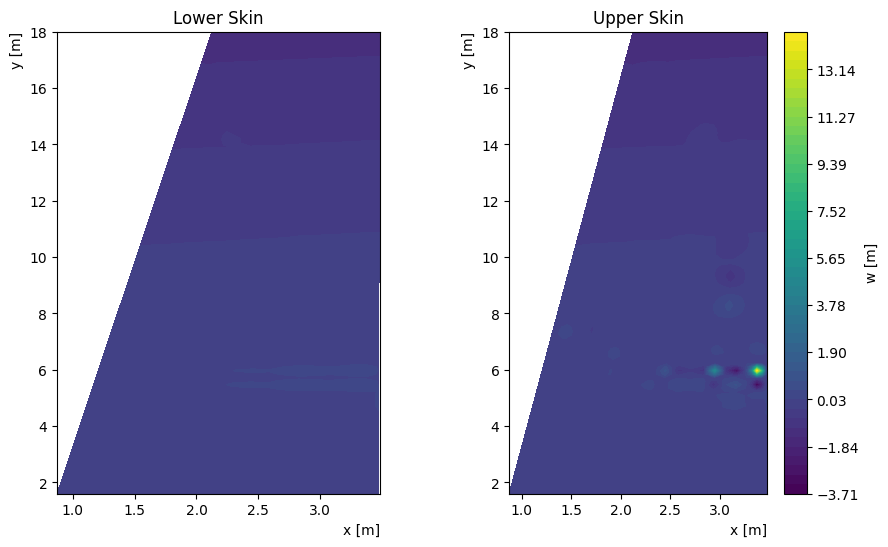

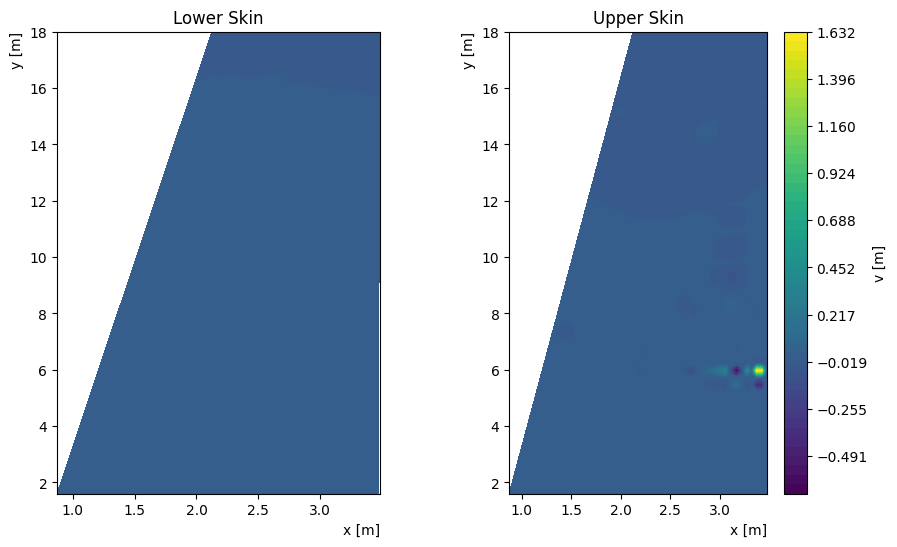

In [11]:
'''Standard deflection plots to check the solution's quality'''
wfig = bl.plot_block(sol['w'], "w", meshOut, csts)
vfig = bl.plot_block(sol['v'], "v", meshOut, csts)

## Ill-conditioning, son

In [12]:
'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev1 = ssl.eigs(A, which='LM')
    print(f"lagest eig:{ew1}")
    print("SM starts")
    ew2, ev2 = ssl.eigs(A, sigma=1e9, which="LM")   #<--- takes a long time
    print(f"smallest eig:{ew1}")

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    # bl.plot_block(ev1[0::pf3.DOF, 0], "evBIGx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev1[2::pf3.DOF, 1], "evBIGx2", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[0::pf3.DOF, 0], "evSMALLx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[2::pf3.DOF, 1], "evSMALLx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of Kuu-KAuu: {condition_check(sol["KC0uu"]-sol["KAuu"])}")
print(f"condition num of M: {condition_check(meshOut["M"])}")

lagest eig:[9.35978608e+11+0.j 9.35539234e+11+0.j 6.52331116e+11+0.j
 6.52783182e+11+0.j 3.76081440e+11+0.j 3.75608043e+11+0.j]
SM starts
smallest eig:[9.35978608e+11+0.j 9.35539234e+11+0.j 6.52331116e+11+0.j
 6.52783182e+11+0.j 3.76081440e+11+0.j 3.75608043e+11+0.j]
condition num of Kuu-KAuu: 936.4763864127527
lagest eig:[385.95172731+0.j 379.65756486+0.j 386.68678768+0.j 386.68678767+0.j
 377.56198056+0.j 377.56198057+0.j]
SM starts
smallest eig:[385.95172731+0.j 379.65756486+0.j 386.68678768+0.j 386.68678767+0.j
 377.56198056+0.j 377.56198057+0.j]
condition num of M: 1.0241677105580083


# Post processor - attempt 2

In [6]:
def update_after_displacement(meshOut:ty.Dict[str, object], sol:ty.Dict[str, object]):
    "Returns the KG matrix and internal force vector after the displacements from the solver are applied"
    KC0, M, N, x, y, z, mesh, up, ids, pts, nid_pos, ncoords = tuple(meshOut[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts', 'nid_pos', 'ncoords'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOut[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOut["N"])
    u, bu, bk, Kuu = tuple(sol[k] for k in ["u", "bu", "bk", "KC0uu"])


    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_ue(u)
        quad.update_probe_xe(ncoords_flatten)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)
    
    for beam in eleDict["beam"]:
        beam.update_probe_ue(u)
        beam.update_probe_xe(ncoords_flatten)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop)

    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]

    return fi, KGuu, KG
    


In [ ]:
fi, KGuu, KG = update_after_displacement(meshOut, sol)
#NOTE: te very high values in fi are the reaction forces
bl.plot_block(fi[0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
bl.plot_block(fi[5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")

lagest eig:[-2.91334039e+10+0.j -7.38780594e+09+0.j  5.50779794e+09+0.j
  2.92613432e+09+0.j  1.78892767e+09+0.j -1.58631914e+09+0.j]
SM starts
smallest eig:[-2.91334039e+10+0.j -7.38780594e+09+0.j  5.50779794e+09+0.j
  2.92613432e+09+0.j  1.78892767e+09+0.j -1.58631914e+09+0.j]
condition num of KGuu: 237.78607557663977


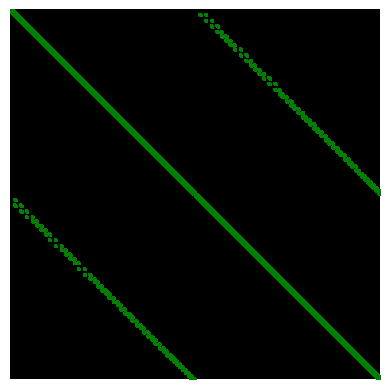

In [8]:
'''Visualise the KG matrix'''
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='green', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

plot_coo_matrix(KGuu)

'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev1 = ssl.eigs(A, which='LM')
    print(f"lagest eig:{ew1}")
    print("SM starts")
    ew2, ev2 = ssl.eigs(A, sigma=1e9, which="LM")   #<--- takes a long time
    print(f"smallest eig:{ew1}")

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    # bl.plot_block(ev1[0::pf3.DOF, 0], "evBIGx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev1[2::pf3.DOF, 1], "evBIGx2", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[0::pf3.DOF, 0], "evSMALLx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[2::pf3.DOF, 1], "evSMALLx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of KGuu: {condition_check(KGuu)}")

In [ ]:
def buckling(sol:ty.Dict[str, object], meshOut:ty.Dict[str, object], KGuu:nt.NDArray[np.float64]):
    K_KAuu = sol["KC0uu"]-sol["KAuu"]
    n_modes = 10 #NOTE: we only care about the load multiplier being smaller/greater than 1, but leave the k higher for accuracy
    eigenvects = np.zeros((meshOut["N"], n_modes), dtype=np.complex128)

    ew, ev = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=5)
    eigenvects[sol["bu"], :] = ev

    #reformatting the result as load multiplier, eigenvalues and an array of eigenvectors
    return min(ew), ew, eigenvects.T

buckling load multiplier: (2.4996447579137184-0.0012777264402192142j)
eigenvalues for buckling: [2.49964476-0.00127773j 2.49964476+0.00127773j 2.50114475-0.00053269j
 2.50114475+0.00053269j 2.50100616-0.00085402j 2.50100616+0.00085402j
 2.50067586-0.0011801j  2.50067586+0.0011801j  2.50017175-0.0013507j
 2.50017175+0.0013507j ]


c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1568: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1569: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1234: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg, np.float64)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


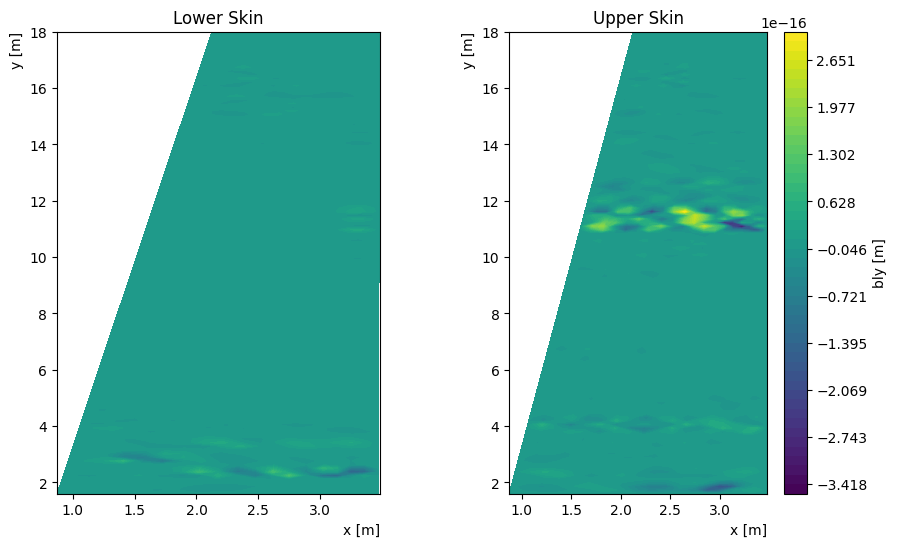

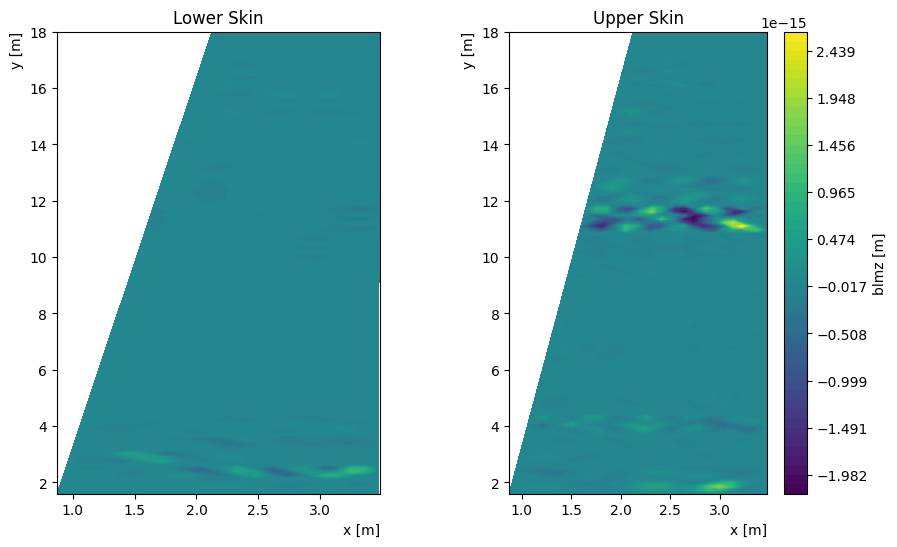

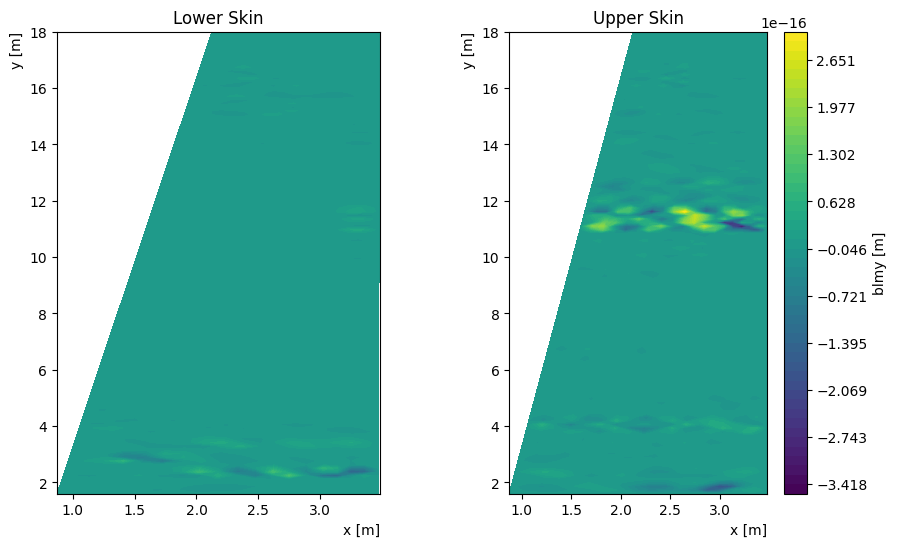

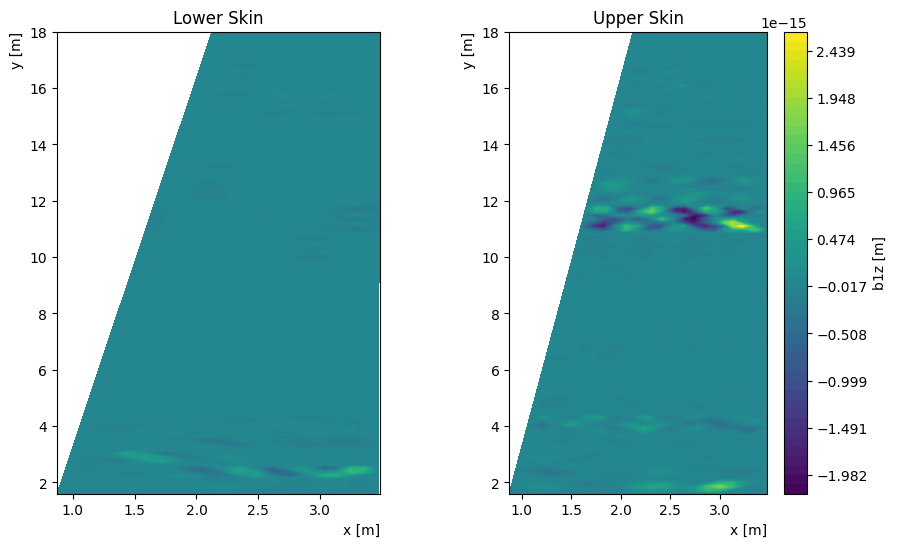

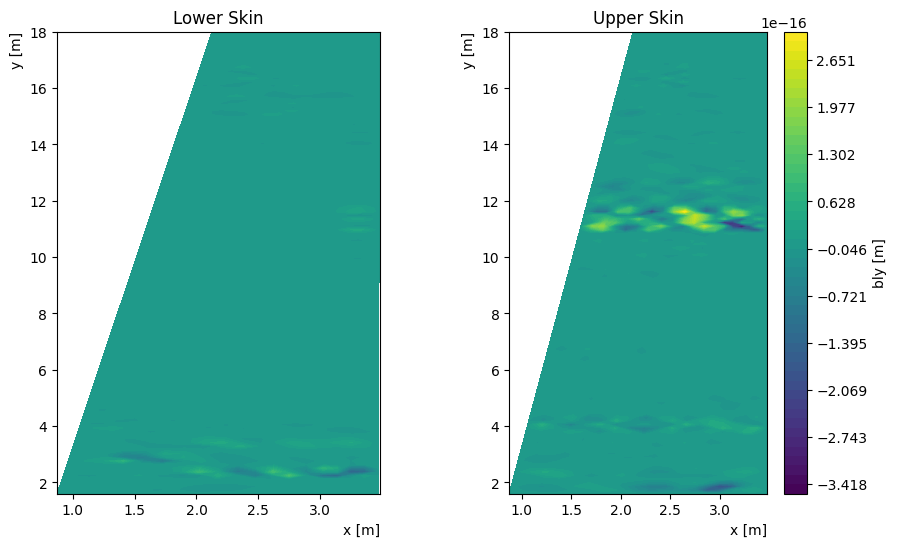

In [34]:
load_mult, ew, ev = buckling(sol, meshOut, KGuu)
print(f"buckling load multiplier: {load_mult}")
print(f"eigenvalues for buckling: {ew}")
bl.plot_block(ev[0, 2::pf3.DOF], "blmz", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[0, 1::pf3.DOF], "blmy", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[1, 2::pf3.DOF], "b1z", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[1, 1::pf3.DOF], "bly", meshOut, cst.CONSTS, "m")

In [12]:
def natfreq(sol:ty.Dict[str, object], meshOut:ty.Dict[str, object]):
    K_KAuu = sol["KC0uu"]-sol["KAuu"]
    Muu = meshOut["M"][sol["bu"], :][:, sol["bu"]]
    n_modes=7#TODO: How many to use
    eigenvects = np.zeros((meshOut["N"], n_modes), dtype=np.complex128)

    ew, ev = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=-1.) #TODO: copy pasted. verify it still holds
    eigenvects[sol["bu"], :] = ev

    #reformatting the result as omega_ns and an array of eigenvectors
    return ew**.5, eigenvects.T


natural frequencies: [0.00026552+1.00049704j 0.00026552-1.00049704j 0.00034571+1.00045422j
 0.00034571-1.00045422j 0.00056399+0.99981378j 0.00056399-0.99981378j
 0.00061383+0.99998396j]


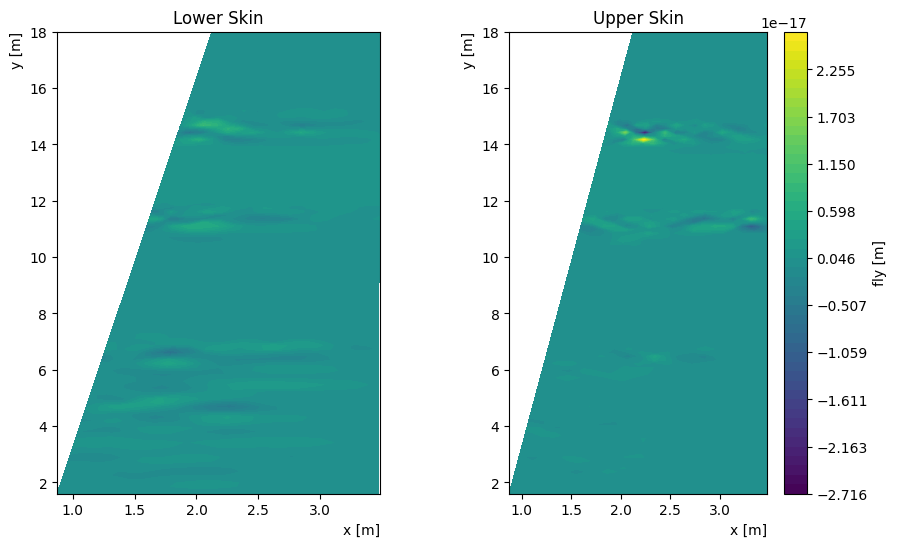

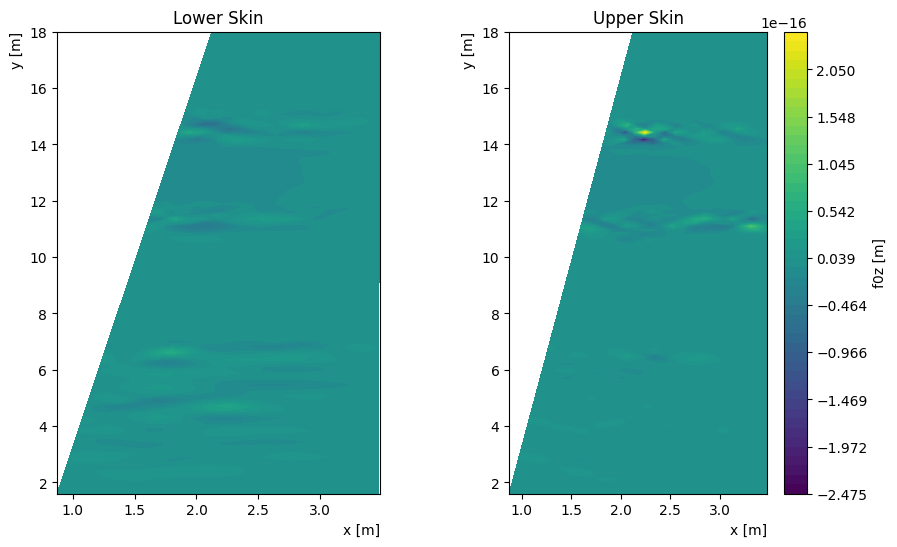

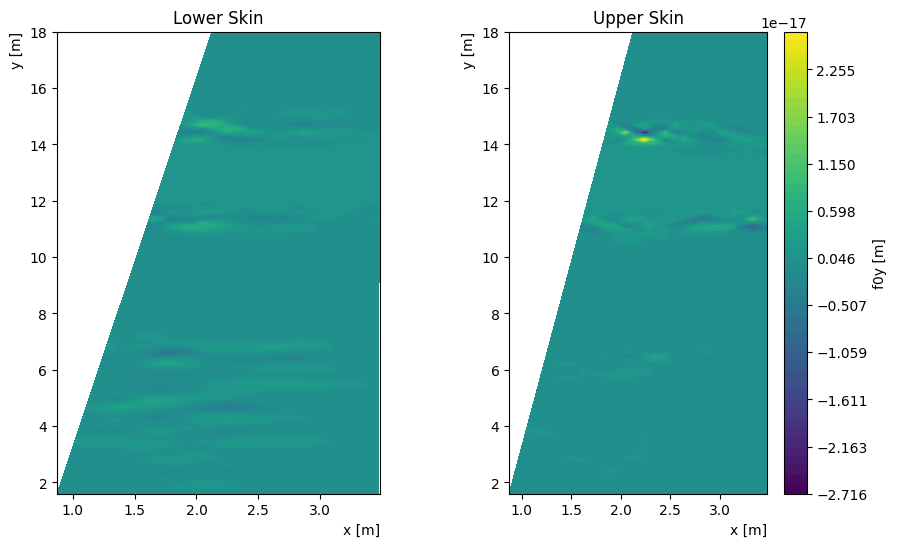

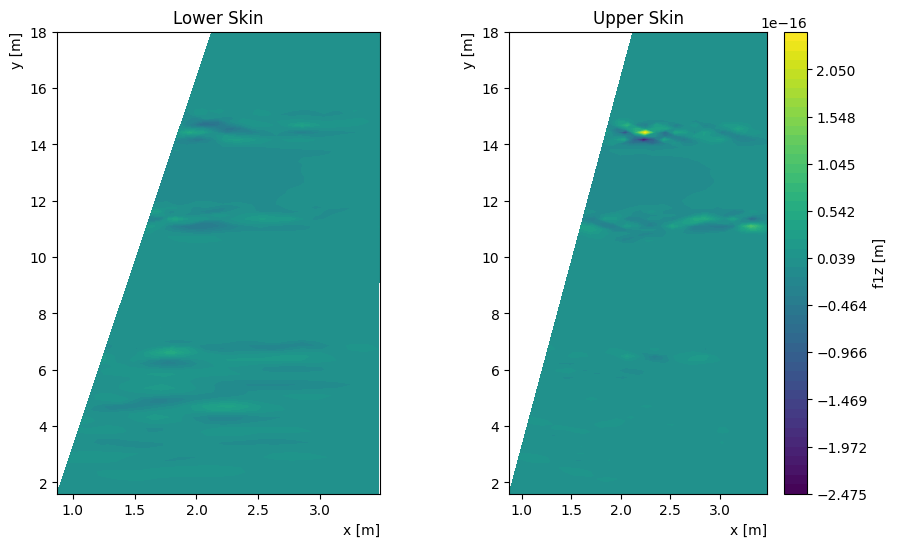

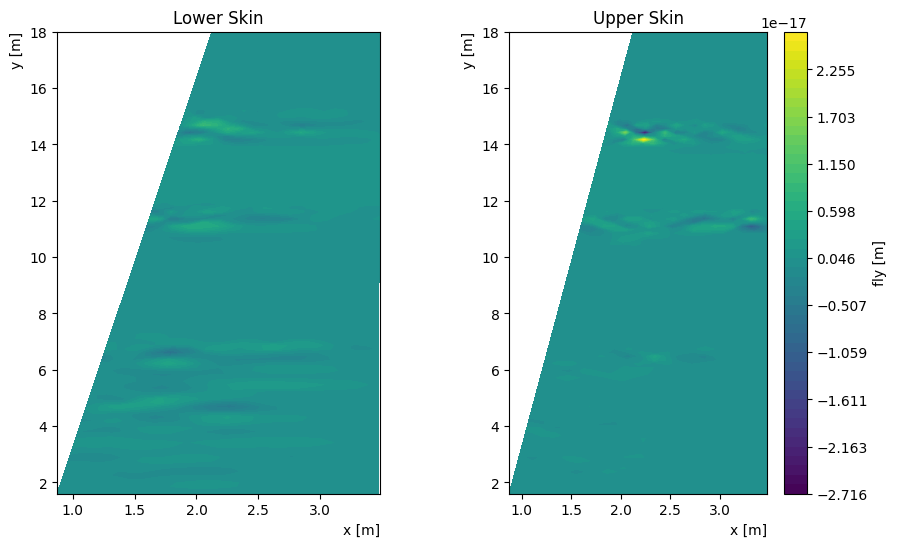

In [13]:
omega_n, omega_v = natfreq(sol, meshOut)

print(f"natural frequencies: {omega_n}")
bl.plot_block(omega_v[0, 2::pf3.DOF], "f0z", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[0, 1::pf3.DOF], "f0y", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[1, 2::pf3.DOF], "f1z", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[1, 1::pf3.DOF], "fly", meshOut, cst.CONSTS, "m")

# Post Processor - internal forces and margins for every failure mode

In [6]:
def flutter_block(consts:ty.Dict[str, object], meshOuts:ty.Dict[str, object], lc:ty.Dict[str, object], sol:ty.Dict[str, object]):
    les, tes, up, M, N = [meshOuts[k] for k in ["les", "tes", "up", "M", "N"]]
    foils, bres, cres, velocities, airfs = [consts[k] for k in ["FOILS", "BRES", "CRES", "VELOCITIES", "FOILS"]]
    op, nlg = [lc[k] for k in ["op", "nlg"]]
    ncoords_s, ids_s, bu, Kuu = [sol[k] for k in ["ncoords_s", "ids_s", "bu", "KC0uu"]]
    airplane, vlm, forces, moments = ls.vlm(les, tes, airfs, op, bres, cres, np.zeros(len(airfs)))
    W, Fext = ls.aero2fem(vlm, ncoords_s, ids_s, N, pf3.DOF)
    W_u_to_p = ls.fem2aero(les, np.zeros(len(foils)), ncoords_s, ids_s, N, pf3.DOF)

    #natural freqs for flutter
    return ls.flutter_omegans(velocities, M, bu, W_u_to_p, Kuu, W, les, tes, airfs, op, up.fft.y, bres, cres)


In [6]:
def rotate_2_local(ele, id_node, ncoords):
    xg, yg, zg = ncoords[id_node]
    xe = ele.r11*xg+ele.r21*yg+ele.r31*zg
    ye = ele.r12*xg+ele.r22*yg+ele.r32*zg
    ze = ele.r13*xg+ele.r23*yg+ele.r33*zg
    return xe, ye, ze

def quad_plate_stress(ele, finte_part, wxe, wye):
    Fxe, Fye, Fze, Mxe, Mye, Mze = np.asanyarray(finte_part)

    #plane stresses
    sx = Fxe/wye/ele.shellprop.h
    sy = Fye/wxe/ele.shellprop.h
    sxC = sx-abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    sxT = sx+abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    syC = sy-abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)
    syT = sy+abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)

    #out-of-plane stresses TODO verify
    tz = np.abs(Fze)/min(wye, wxe)/ele.shellprop.h #we make the worse wall assumption, that the shear flows in a different direction than we might want it to 
    #for now, we assume no modification due to Mze TODO add that
    return np.array([sxC, sxT, syC, syT, tz, sx, sy]) #we keep sx, sy for future mohr circle caluclations


'''COPYPASTE THIS TO blocks.py ONCE DONE!!!'''
def stress_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], debug=False):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts, nid_pos, ncoords = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts', 'nid_pos', 'ncoords'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOuts["N"])
    u, bu, bk, Kuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu"])

    '''INTERNAL LOADS'''
    #only for quads and beams as of now - that's all we are using
    sigma_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    tau_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    sorted_eles = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_ue(u)
        quad.update_probe_xe(ncoords_flatten)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)

        "stresses"
        #transferring nodes into local coord system
        xe1, ye1, ze1 = rotate_2_local(quad, nid_pos[quad.n1], ncoords)
        xe2, ye2, ze2 = rotate_2_local(quad, nid_pos[quad.n2], ncoords)
        xe3, ye3, ze3 = rotate_2_local(quad, nid_pos[quad.n3], ncoords)
        xe4, ye4, ze4 = rotate_2_local(quad, nid_pos[quad.n4], ncoords)

        #getting the widths of the element - we have some very elongated element, so necessary to consider
        #current algorithm is wxe*wye=SA, wxe~max(xes)-min(xes), wyeb similarly
        #area by two cross products
        SA = .5*np.linalg.norm(np.cross([xe4-xe1, ye4-ye1, ze4-ze1], [xe2-xe1, ye2-ye1, ze2-ze1]))+.5*np.linalg.norm(np.cross([xe1-xe2, ye1-ye2, ze1-ze2], [xe3-xe2, ye3-ye2, ze3-ze2]))
        wxeprop=max(xe1, xe2, xe3, xe4)-min(xe1, xe2, xe3, xe4)
        wyeprop=max(ye1, ye2, ye3, ye4)-min(ye1, ye2, ye3, ye4)
        c = np.sqrt(SA/wxeprop/wyeprop)
        wxe = wxeprop*c
        wye = wyeprop*c

        #stress calculation for the four nodes - then averaged
        stresses1 = quad_plate_stress(quad, quad.probe.finte[:6], wxe, wye)
        stresses2 = quad_plate_stress(quad, quad.probe.finte[6:12], wxe, wye)
        stresses3 = quad_plate_stress(quad, quad.probe.finte[12:18], wxe, wye)
        stresses4 = quad_plate_stress(quad, quad.probe.finte[18:], wxe, wye)
        stresses = (stresses1+stresses2+stresses3+stresses4)/4

        #further individual post-processing and saving of the results
        if quad.eleid == codes["skin"]:
            tau_most["quad"][codes["skin"]].append(stresses[4])
            sigma_most["quad"][codes["skin"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["skin"]].append(quad)

        elif quad.eleid == codes["panelRib"]:
            tau_most["quad"][codes["panelRib"]].append(stresses[4])
            sigma_most["quad"][codes["panelRib"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelRib"]].append(quad)

        elif quad.eleid == codes["panelPlate"]:
            tau_most["quad"][codes["panelPlate"]].append(stresses[4])
            sigma_most["quad"][codes["panelPlate"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelPlate"]].append(quad)

        elif quad.eleid == codes["spar"]:
            tau_most["quad"][codes["spar"]].append(stresses[4])
            sigma_most["quad"][codes["spar"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["spar"]].append(quad)

        else: raise NotImplementedError(f"A quad element of eleid {quad.eleid} not accounted for in post-processing!")

    for beam in eleDict["beam"]:
        beam.update_probe_ue(u)
        beam.update_probe_xe(ncoords_flatten)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop) 

        "stresses"
        Fx1, Fy1, Fz1, Mx1, My1, Mz1 = beam.probe.finte[:6]

        A, J, Iyy, Izz = beam.beamprop.A, beam.beamprop.J, beam.beamprop.Iyy, beam.beamprop.Izz 

        if beam.eleid == codes["rail"]:
            #normal stress
            sigma_most["beam"][codes["rail"]].append(abs(Fx1)/A+din/2*np.sqrt((Mz1/Izz)**2+(My1/Iyy)**2))
                                                     
            #shear stress - we have to run a maximalisation problem for every node
            radius_fun = lambda xe:xe[0]**2+xe[1]**2
            rad_constr = opt.NonlinearConstraint(radius_fun, -1e-6, din**2/4) #TODO: add actual jacobian
            #negative to use minimise
            shearsq_fun1 = lambda xe: -(Mx1*xe[1]/J+Fy1/3/Izz*(din**2/4-xe[0]**2))**2-(Mx1*xe[0]/J+Fz1/3/Iyy*(din**2/4-xe[1]**2))**2
            shearsq1 = opt.minimize(shearsq_fun1, np.array([0,0]), constraints=[rad_constr],
                                    method="Cobyla")
            print(shearsq1) if debug else None
            tau_most["beam"][codes["rail"]].append(np.sqrt(-shearsq1.fun)) #back to actual shear stress

            #saving the element in a matching format
            sorted_eles["beam"][codes["rail"]].append(beam)

        elif beam.eleid == codes["panelFlange"]:
            #most constraining normal stress in when bending stresses are in the same direction as axial stress
            #! For isotropic materials only!
            sigma_most["beam"][codes["panelFlange"]].append(abs(Fx1)/A+(abs(My1)/Iyy*trb/2+abs(Mz1)/Izz*rfl/2))

            #most constraining shear stress - either one of the sides with torsion of the middle
            def tau_most_at_node(Mx, Fy, Fz):
                tau_Mx = abs(Mx)*(3+1.8*trb/rfl)/rfl/trb**2 #directions don't matter, we can get all combinations
                tau_Fz = abs(Fz)*trb**2/8/Iyy
                tau_Fy = abs(Fy)*rfl**2/8/Izz
                return max(tau_Mx+tau_Fz, tau_Mx+tau_Fy, np.sqrt(tau_Fy**2+tau_Fz**2))
            tau_most["beam"][codes["panelFlange"]].append(tau_most_at_node(Mx1, Fy1, Fz1))

            #saving the element in a matching format
            sorted_eles["beam"][codes["panelFlange"]].append(beam)

        else: raise NotImplementedError(f"A beam element of eleid {quad.eleid} not accounted for in post-processing!")
          
    fi[bk] = 0 #to avoid internal force at clamps which can be latge and are weirdly defined
    
    return sorted_eles, tau_most, sigma_most, fi

def eigen_analysis_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], v0b=None, v0f=None, debug=False):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    u, bu, bk, Kuu, KAuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu", "KAuu"])

    if v0b is None:
        v0b = u.copy()
    v0bu = v0b[bu]
    
    if v0f is None:
        v0f = u.copy()
    v0fu = v0f[bu]

    '''BUCKLING ANALYSIS'''
    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]
    num_eig_lb = 4 #We only need one, the load multiplier

    eigvecs = np.zeros((N, num_eig_lb))
    print("buckling eigs started") if debug else None
    eigvals, eigvecsu = ssl.eigs(A=KGuu, k=num_eig_lb, which="LR", M=Kuu-KAuu, tol=1e-8, v0=v0bu)
    print("buckling eigs ended") if debug else None
    eigvals = 1./eigvals
    eigvecs[bu] = eigvecsu 
    load_mult = eigvals[0] #TODO from what it seems to me has to be strictly greater than one
    print("buckling interpreted") if debug else None

    '''EIGENFREQUENCY ANALYSIS'''
    Muu = M[bu, :][:, bu]
    num_eig=6 #TODO: how many
    print("flutter eigs started") if debug else None
    eigvalsO, eigvectsOu = ssl.eigs(A=Kuu-KAuu, M=Muu, sigma=-1., which='LM', #eigs so that we see the complex part
            k=num_eig, tol=1e-8, v0=v0fu)
    print("flutter eigs ended") if debug else None
    omegan = eigvalsO**0.5
    eigvectsO = np.zeros(N, dtype=np.complex128)
    eigvectsO[bu] = eigvectsOu[:, 0]
    print("flutter interpreted") if debug else None

    return KG, KGuu, load_mult, eigvecs, eigvals, omegan, eigvectsO, v0b, v0f

'A WRAPPER FUNCTION FOR ALL POST-PROCESSING'    
def post_processor_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], v0b=None, v0f=None, debug=False):
    
    sorted_eles, tau_most, sigma_most, fi = stress_block(defl, meshOuts, codes, sizerVals, consts, debug)
    KG, KGuu, load_mult, eigvecs, eigvals, omegan, eigvectsO, v0b, v0f = eigen_analysis_block(defl, meshOuts, codes, sizerVals, consts, v0b, v0f, debug)

    return {"elements":sorted_eles, "fi":fi, "KG":KG, "KGuu":KGuu, "load_mult":load_mult, "eigvecs":eigvecs, "eigvals":eigvals, "omegan":omegan,
            "sigma":sigma_most, "tau":tau_most, "flutter_eigvec":eigvectsO, "v0b":v0b, "v0f":v0f}

## Stress

Here be code just for stress sub-block testing

In [8]:
sorted_eles, tau_most, sigma_most, fi = stress_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)


cond KGuu: 3266889617788044.0, KGv: [ 0.          0.          0.         ...  1.78468926 -0.2835665
  1.76516817], KGC: [    0     1     2 ... 34437 34438 34439], KGR: [    0     0     0 ... 34439 34439 34439]


In [ ]:
for r in sorted_eles["quad"][cst.CODES["panelPlate"]]:
    if not np.isclose(np.asanyarray(r.probe.finte).sum(), 0):
        print(np.asanyarray(r.probe.finte))

[ 1.77964577e+04  1.15888556e+04  6.71504560e+02  9.94250720e+00
  1.10935094e+01  0.00000000e+00 -3.08507112e+03  4.62328238e+03
  8.53595290e+02  1.03638555e+01  1.10750764e+01 -6.13813730e-02
 -8.21098839e+03 -5.92453004e+03 -6.71504560e+02  8.63117406e+00
  1.14945337e+01  2.98372438e-15 -6.50039814e+03 -1.02876080e+04
 -8.53595290e+02  9.10621826e+00  1.14072536e+01  0.00000000e+00]
[ 1.76198454e+04  1.02835008e+04 -6.00194303e+02 -9.15906450e+00
 -7.47265907e-01  0.00000000e+00 -1.03467392e+03  4.14647890e+03
 -6.19227363e+02 -1.07888054e+01 -9.29148632e-01  2.98155597e-15
 -8.89779582e+03 -5.63784017e+03  6.00194303e+02 -4.46946680e+00
 -6.96719466e-01 -6.08129343e-02 -7.68737570e+03 -8.79213954e+03
  6.19227363e+02 -6.00124810e+00 -5.82402898e-01  0.00000000e+00]
[ 2.96490440e+04  1.48613792e+04 -6.23341181e+02 -1.79481468e+01
 -2.04628400e+00  0.00000000e+00  7.47457486e+03  5.57314599e+03
 -6.72601347e+02 -1.77359904e+01 -1.98985380e+00 -6.08129343e-02
 -2.79727676e+04 -1.324

In [ ]:
import pyvista
pyvista.set_plot_theme('document')
pyvista.set_jupyter_backend('trame')
pyvista.global_theme.window_size = [600, 400]
pyvista.global_theme.axes.show = True
pyvista.global_theme.anti_aliasing = 'fxaa'
pyvista.global_theme.show_scalar_bar = True

In [ ]:
print("BEAMS:")
print(f"sigma rail: max: {max(sigma_most["beam"][cst.CODES["rail"]])}, min:{min(sigma_most["beam"][cst.CODES["rail"]])}")
print(f"tau rail: max: {max(tau_most["beam"][cst.CODES["rail"]])}, min:{min(tau_most["beam"][cst.CODES["rail"]])}")
print(f"sigma flange: max: {max(sigma_most["beam"][cst.CODES["panelFlange"]])}, min:{min(sigma_most["beam"][cst.CODES["panelFlange"]])}")
print(f"tau flange: max: {max(tau_most["beam"][cst.CODES["panelFlange"]])}, min:{min(tau_most["beam"][cst.CODES["panelFlange"]])}")
print("\nQUADS:")
print(f"tau rib: max: {max(tau_most["quad"][cst.CODES["panelRib"]])}, min:{min(tau_most["quad"][cst.CODES["panelRib"]])}")
print(f"sigma rib: max: {max(sigma_most["quad"][cst.CODES["panelRib"]])}, min:{min(sigma_most["quad"][cst.CODES["panelRib"]])}")
print(f"tau plate: max: {max(tau_most["quad"][cst.CODES["panelPlate"]])}, min:{min(tau_most["quad"][cst.CODES["panelPlate"]])}")
print(f"sigma plate: max: {max(sigma_most["quad"][cst.CODES["panelPlate"]])}, min:{min(sigma_most["quad"][cst.CODES["panelPlate"]])}")
print(f"tau skin: max: {max(tau_most["quad"][cst.CODES["skin"]])}, min:{min(tau_most["quad"][cst.CODES["skin"]])}")
print(f"sigma skin: max: {max(sigma_most["quad"][cst.CODES["skin"]])}, min:{min(sigma_most["quad"][cst.CODES["skin"]])}")
print(f"tau spar: max: {max(tau_most["quad"][cst.CODES["spar"]])}, min:{min(tau_most["quad"][cst.CODES["spar"]])}")
print(f"sigma spar: max: {max(sigma_most["quad"][cst.CODES["spar"]])}, min:{min(sigma_most["quad"][cst.CODES["spar"]])}")

BEAMS:
sigma rail: max: 1119132246.1913362, min:1535686.4050986674
tau rail: max: 158691127.51680216, min:7005.278710748705
sigma flange: max: 1214650827.9986453, min:0.0
tau flange: max: 487207343.4667876, min:0.0

QUADS:
tau rib: max: 4040345873.851439, min:0.0
sigma rib: max: 4045908974.619535, min:0.0
tau plate: max: 286621790.9226067, min:19200.00384491906
sigma plate: max: 9958402889.746511, min:3150613.0825423663
tau skin: max: 155944610.17776197, min:11534.055317984672
sigma skin: max: 5482070681.774746, min:1978933.3791966133
tau spar: max: 323608076.12345356, min:5659.113866032499
sigma spar: max: 1430998884.7901933, min:1791120.526918631


In [ ]:
import pyvista as pv

edges = []
sigmas = []
taus = []
sigma_max = max(sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]])
tau_max = max(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]])
tau_argmax = np.array(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][cst.CODES["rail"]]+sorted_eles["beam"][cst.CODES["panelFlange"]],
                         sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]],
                         tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append((1-sgm/sigma_max))
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=False,
    background='w',)

Sigma_max: 1214650827.9986453; Tau_max: 487207343.4667876
2.286474093986103 3.67346 0.3299765187305353
2.332338944870541 3.67346 0.3299765226555786
[3687095.00702971 2713605.55391684 8464000.23183472 ... 5323174.91997329
 3853120.28998198 1801099.0080875 ]


Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277af674230_0&reconnect=auto" class="pyvis…

In [ ]:
import pyvista as pv

edges = []
sigmas = []
taus = []
code = cst.CODES["panelFlange"]
sigma_max = max(sigma_most["beam"][code])
tau_max = max(tau_most["beam"][code])
tau_argmax = np.array(tau_most["beam"][code]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][code],
                         sigma_most["beam"][code],
                         tau_most["beam"][code]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append(sgm)
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=True,
    background='w',)

Sigma_max: 1214650827.9986453; Tau_max: 487207343.4667876
2.286474093986103 3.67346 0.3299765187305353
2.332338944870541 3.67346 0.3299765226555786
[9380459.78277453 2559942.68417744 6712963.46270296 ... 5323174.91997329
 3853120.28998198 1801099.0080875 ]


Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277a78aa270_1&reconnect=auto" class="pyvis…

In [ ]:
import pyvista as pv
pl = pv.Plotter()
ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
conns = list()
code = cst.CODES["spar"]

for quad in sorted_eles["quad"][code]:
    conns+=[4, nid_pos[quad.n1], nid_pos[quad.n2], nid_pos[quad.n3], nid_pos[quad.n4]]

conns = np.array(conns)
types = [pv.CellType.QUAD]*len(sorted_eles["quad"][code])

pl.show_axes()
pl.add_mesh(pv.UnstructuredGrid(conns, types, ncoords), scalars=sigma_most["quad"][code])
pl.add_scalar_bar()
pl.show()

Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277a7c5af00_2&reconnect=auto" class="pyvis…

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cst.CONSTS["VELOCITIES"], flutter_block(cst.CONSTS, meshOut, load_case, sol))

NameError: name 'flutter_block' is not defined

## full tests

In [7]:
import datetime
print(f"matrix size: {meshOut["N"]}, sparsity: {1-meshOut["KC0"].count_nonzero()/meshOut["N"]**2}")
print(f"\ntime1: {datetime.datetime.now()}")
ppd = post_processor_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])
print(f"\ntime2: {datetime.datetime.now()}")
ppd = post_processor_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS, v0b=ppd["v0b"], v0f=ppd["v0f"])
print(f"\ntime3: {datetime.datetime.now()}")
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])


matrix size: 104832, sparsity: 0.9994644574306856

time1: 2025-08-11 20:53:40.938485


C:\Users\marri\AppData\Local\Temp\ipykernel_60968\3954406708.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvecs[bu] = eigvecsu


KeyboardInterrupt: 

In [ ]:
'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev = ssl.eigsh(A, which='LM')
    ew2, ev = ssl.eigsh(A, sigma=1e-8)   #<--- takes a long time

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
    bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of KGuu: {condition_check(ppd["KGuu"])}")
print(f"condition num of Kuu-KAuu: {condition_check(sol["KC0uu"]-sol["KAuu"])}")
print(f"condition num of M: {condition_check(meshOut["M"])}")

condition num of KGuu: 7911065097026842.0
condition num of Kuu-KAuu: 1707382825.6242278
condition num of M: 10393706106.97204


[0.01295583+0.j 0.01691414+0.j 0.02978869+0.j 0.03299169+0.j]
(0.012955825427643907+0j)
[0.6278749 +0.j 0.63005854+0.j 0.64021099+0.j 0.64339021+0.j
 0.64188498+0.j 0.64199843+0.j]


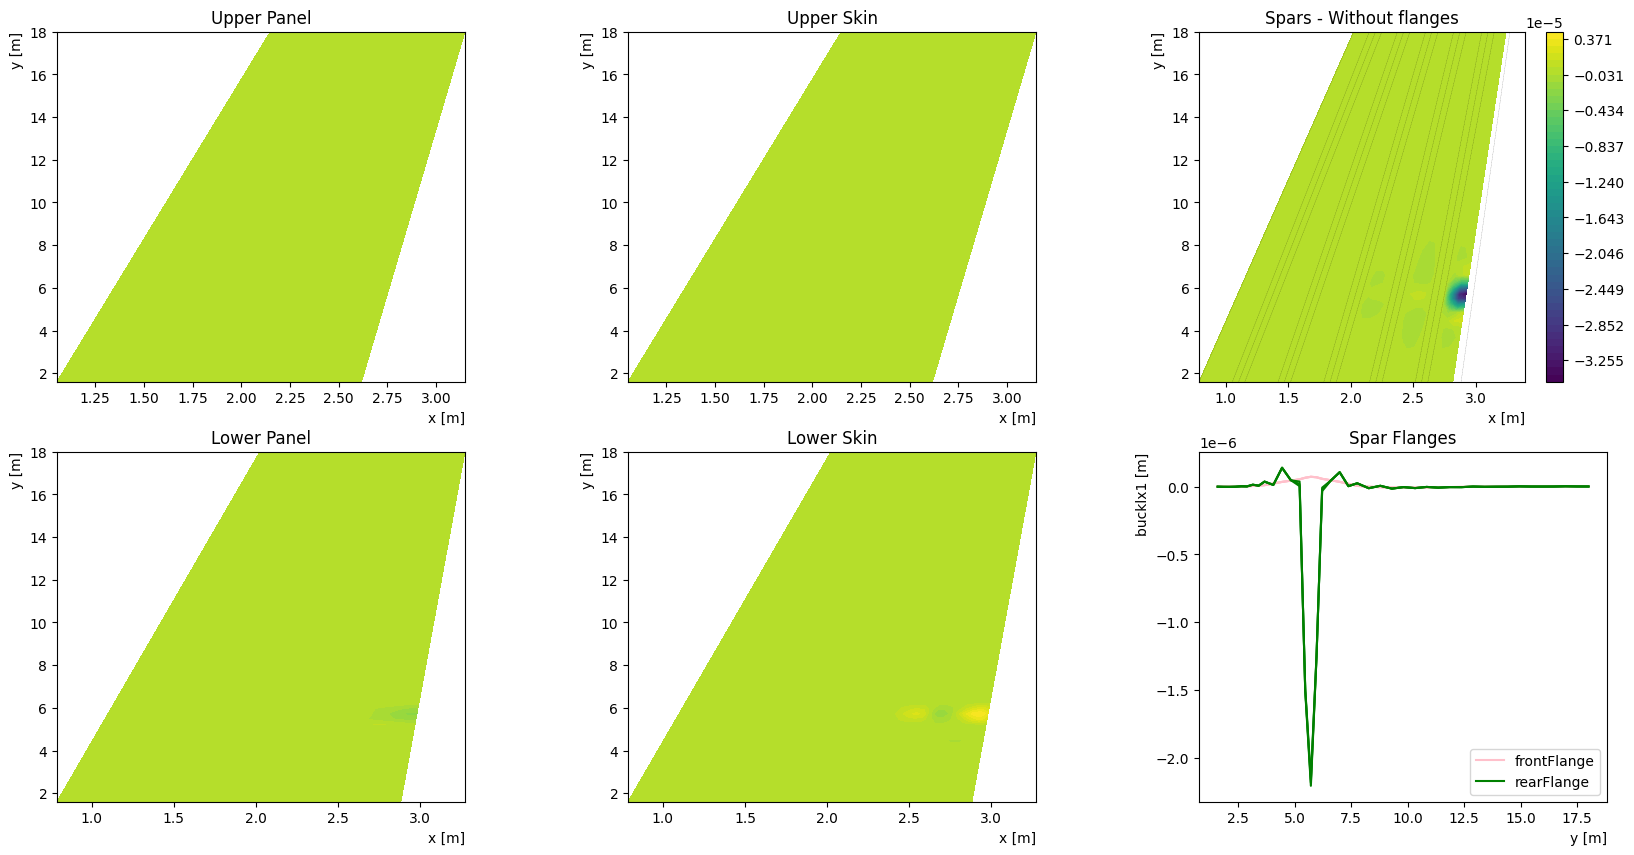

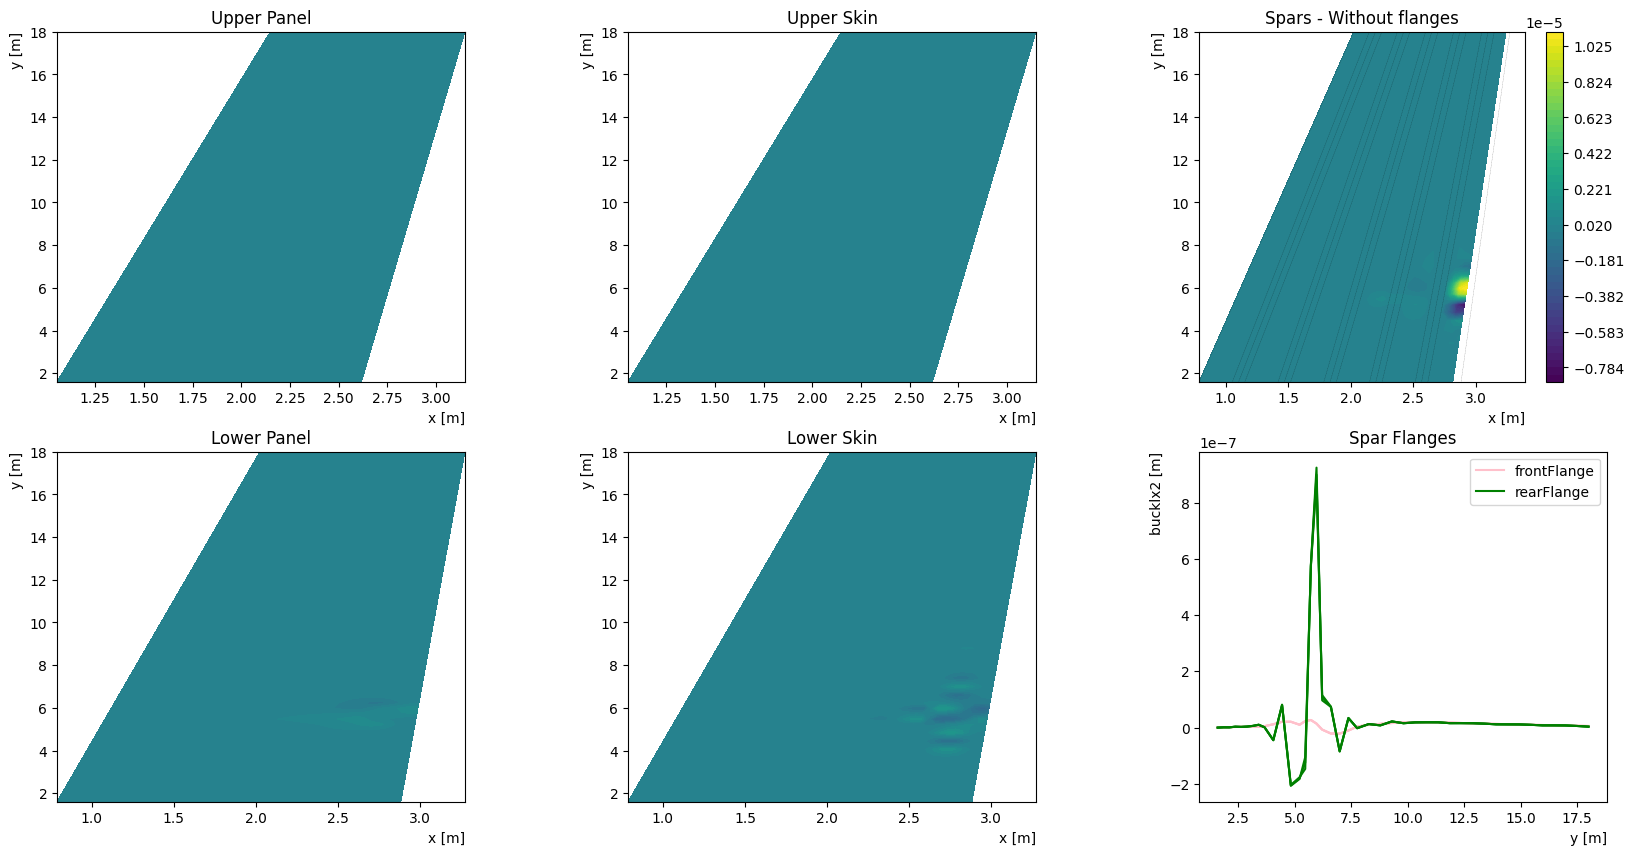

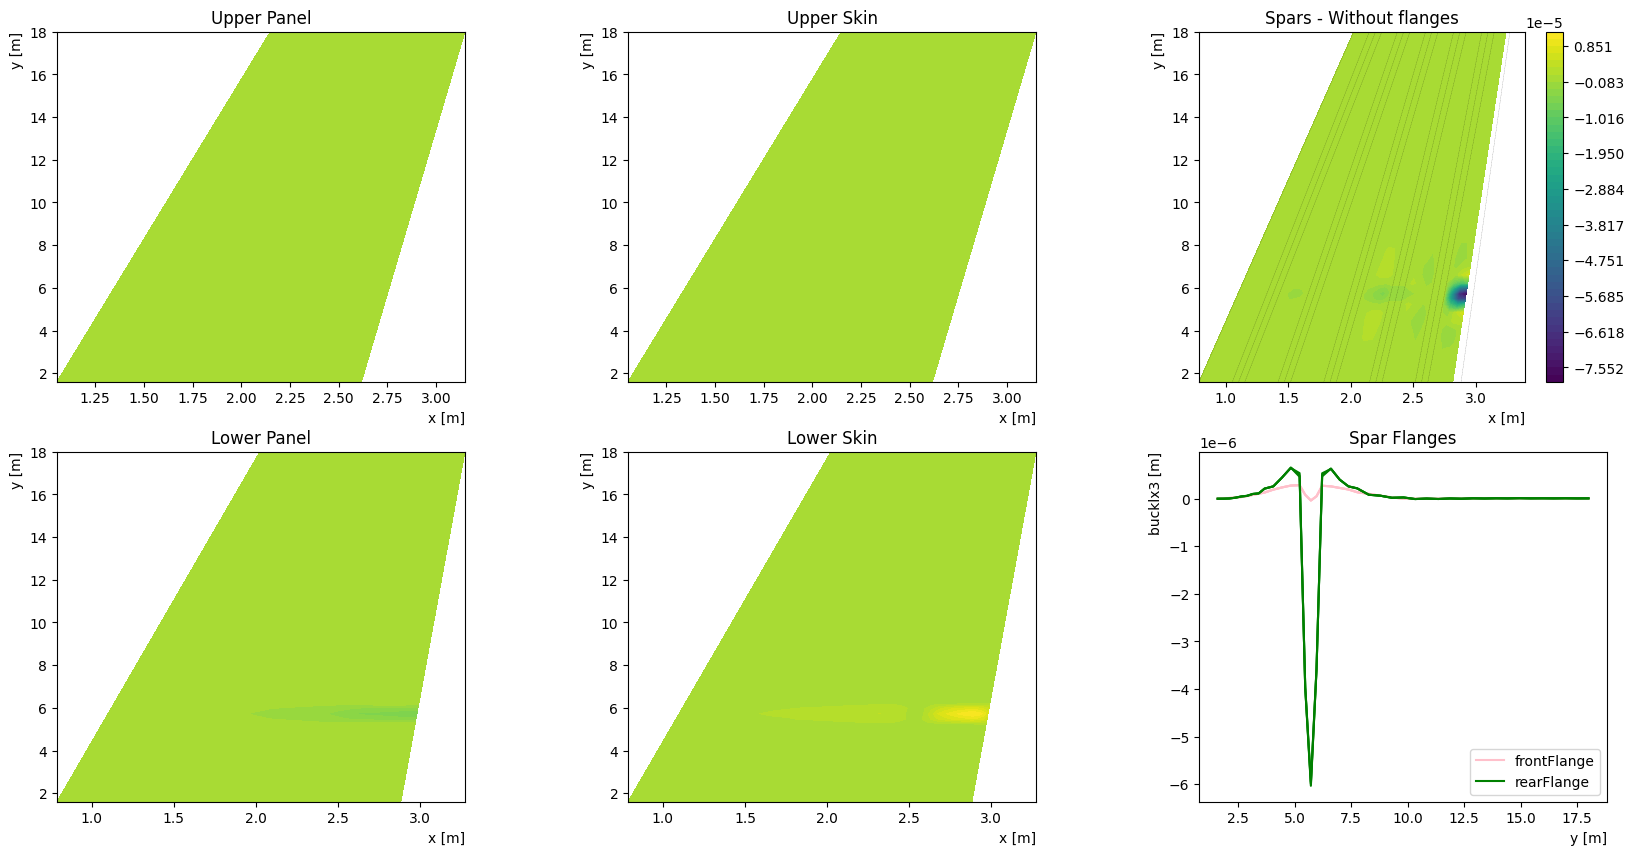

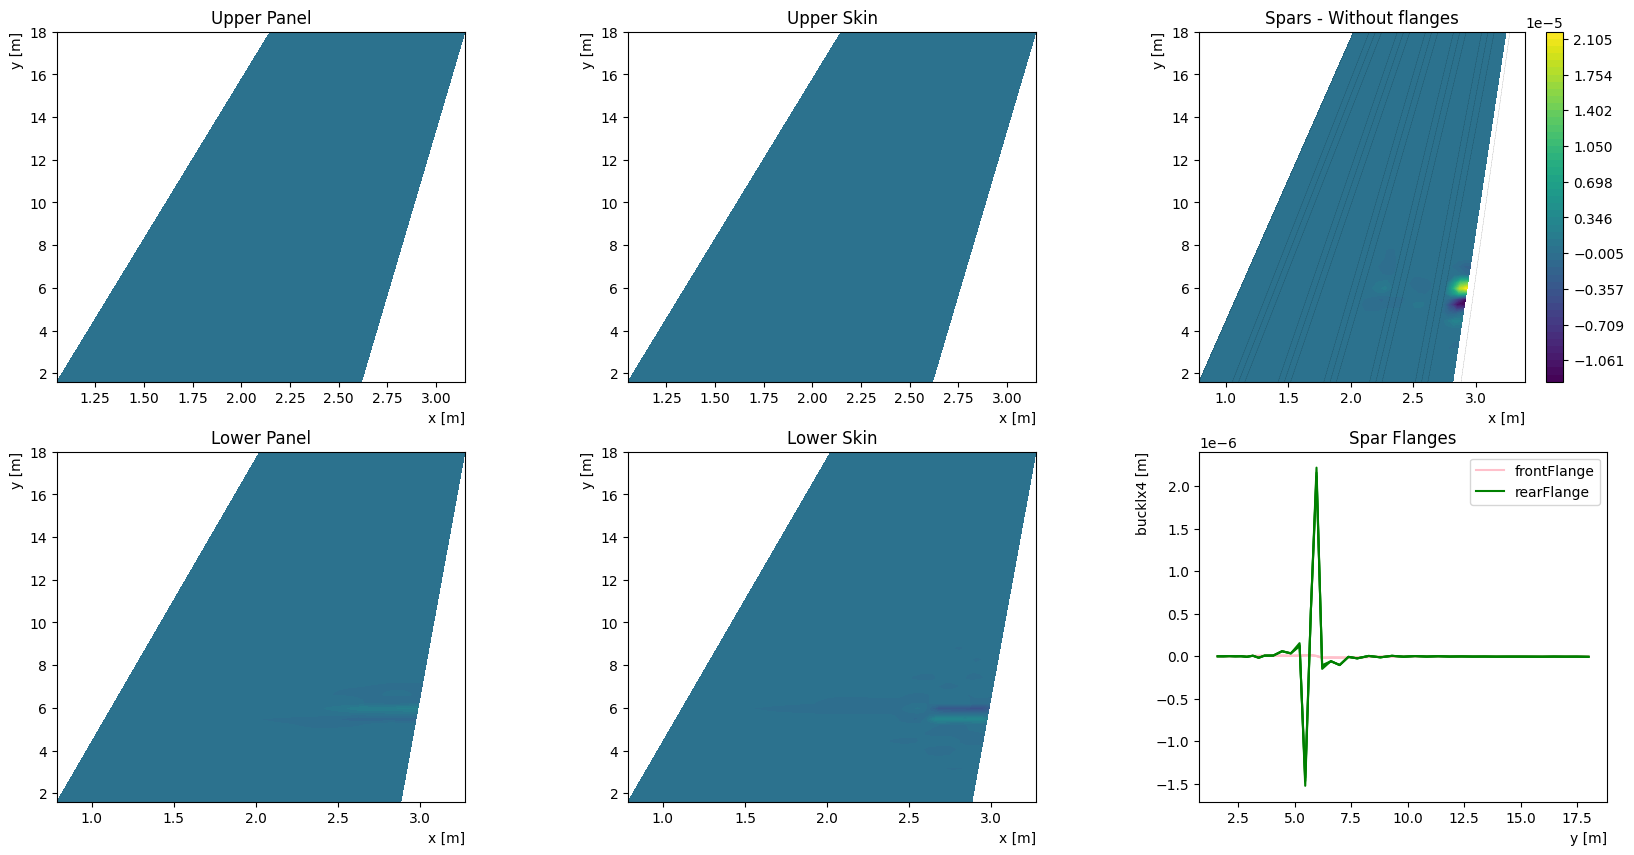

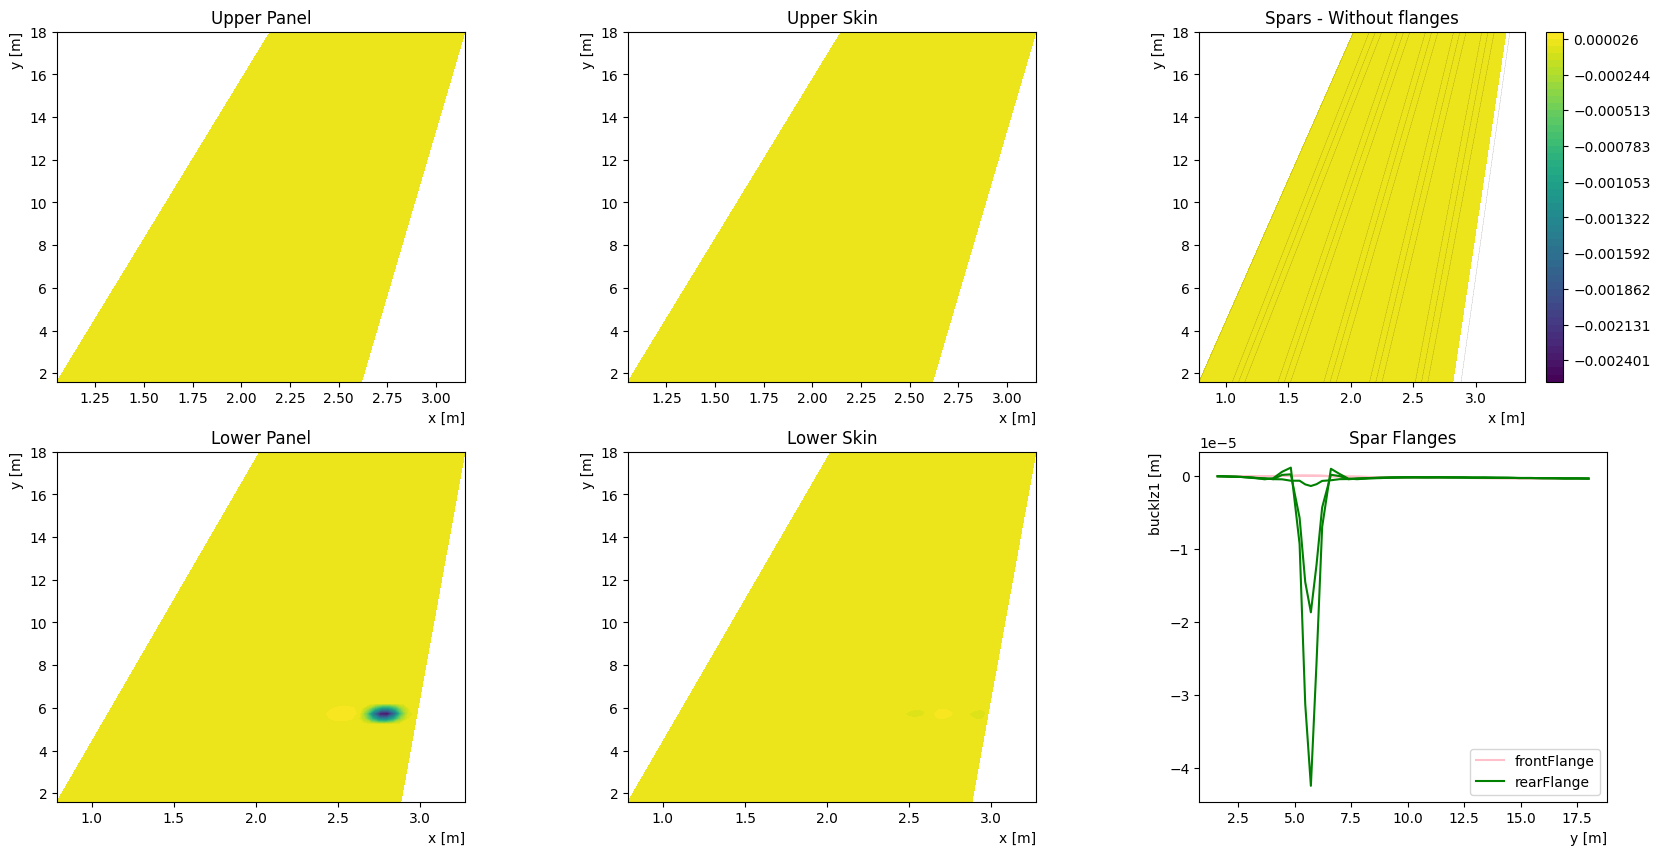

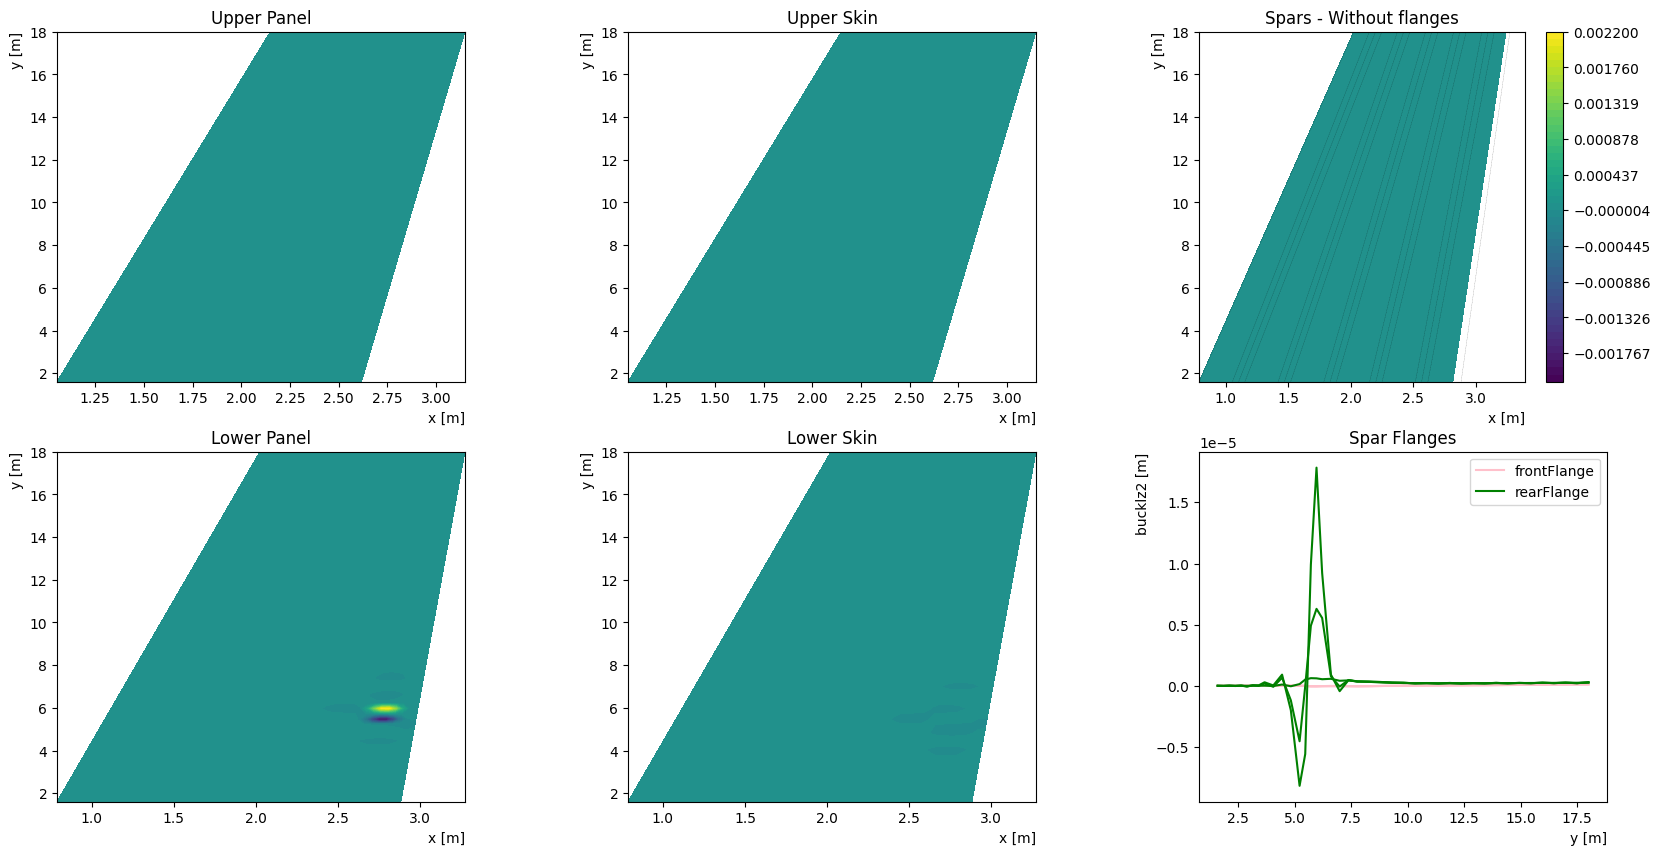

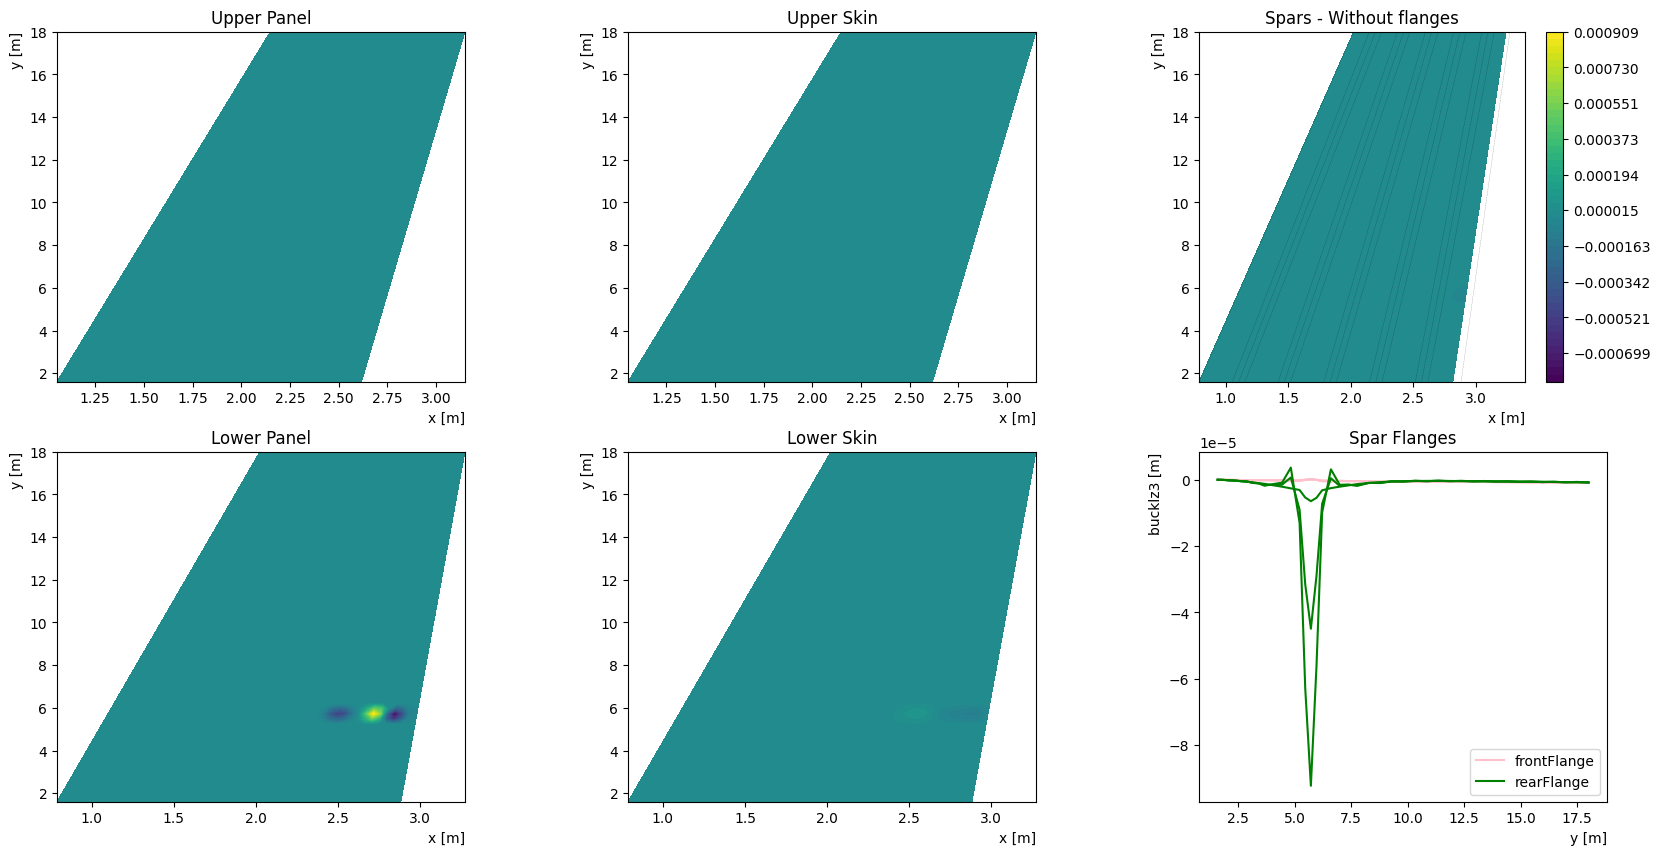

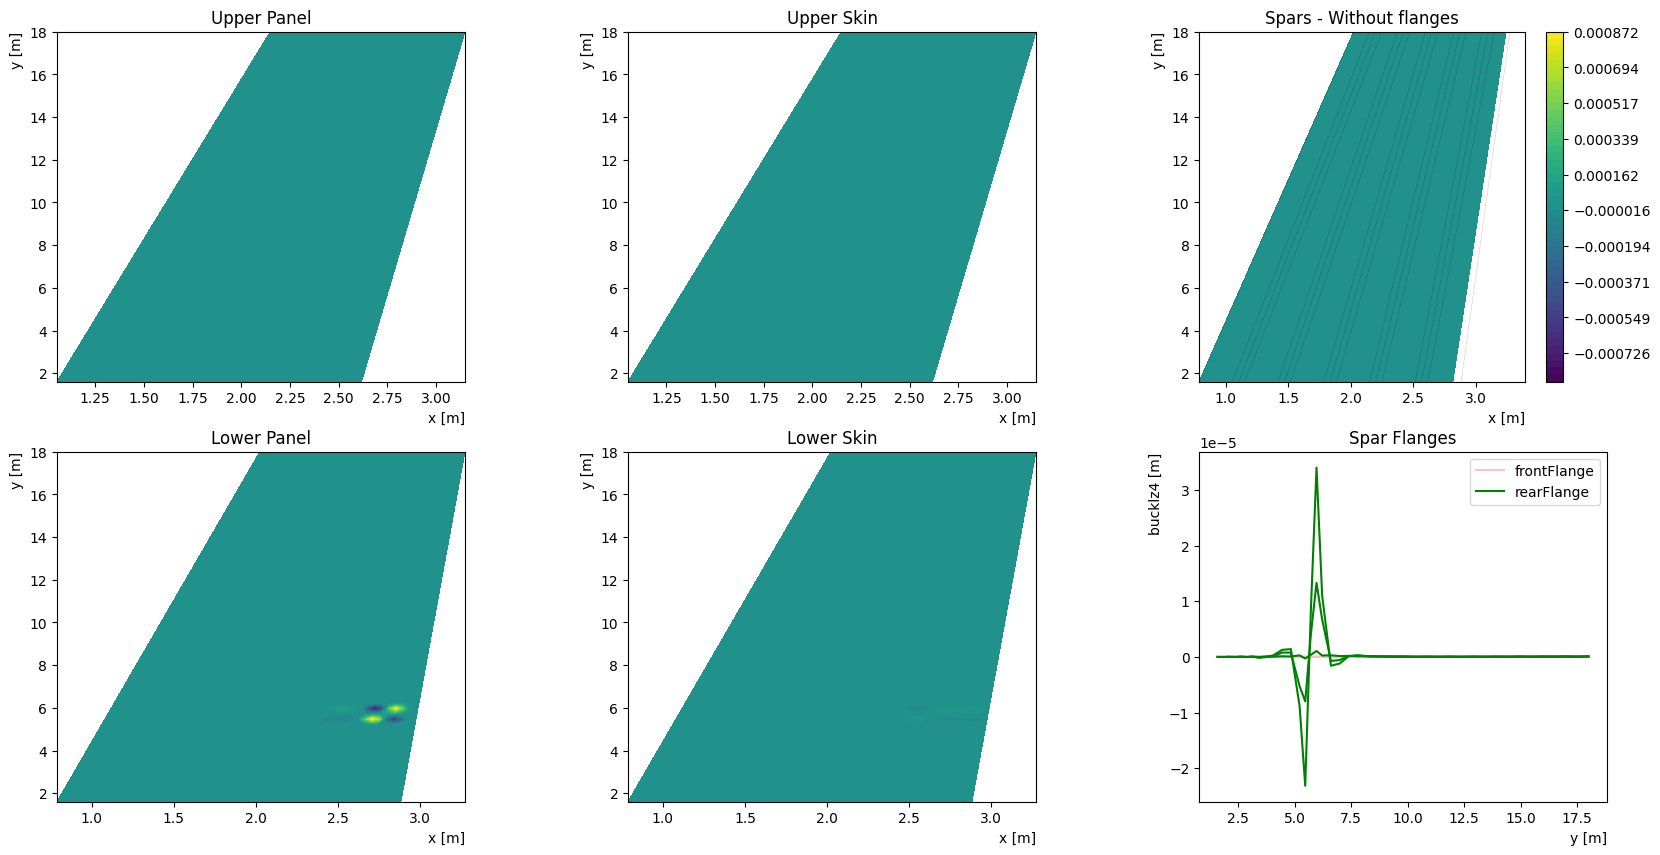

In [13]:
# bl.plot_block(ppd["fi"][0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 2], "bucklx3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 3], "bucklx4", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 0], "bucklz1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 1], "bucklz2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 2], "bucklz3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 3], "bucklz4", meshOut, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])

# Sizer

In [ ]:

'''A separate cache for eigenvectors'''
v0b = [None]*len(cst.LOAD_C)
v0f = [None]*len(cst.LOAD_C)

@ftl.cache
def _function_optim(optimVars:nt.NDArray[np.float64]):
    '''to be wrapped for particular outputs'''
    sizerVars = {
        'tspar':optimVars[0],
        'tskin':optimVars[1],
        'tpan':optimVars[2],
        'trib':optimVars[3],
        'csp':optimVars[4],
    }

    eleDict = ed.eledict(cst.CONSTS, sizerVars, cst.CODES)
    meshOut = bl.mesh_block(cst.CAD_DATA, sizerVars, eleDict, cst.CONSTS, cst.CODES)
    lfems, lppcs = list(), list()
    jmax_omegans, ldms = list(), list()
    for i, lc in enumerate(cst.LOAD_C):
        femres = bl.fem_linear_block(cst.CONSTS, meshOut, lc)
        ppcres = post_processor_block(femres, meshOut, cst.CODES, sizerVars, cst.CONSTS, v0b[i], v0f[i])
        lfems.append(femres)
        lppcs.append(ppcres)
        jmax_omegans.append(max(np.imag(ppcres["omegan"])))
        ldms.append(ppcres["load_mult"])
        v0b[i] = ppcres["v0b"]
        v0f[i] = ppcres["v0f"]
    
    #constraints
    jmax_omegan = max(jmax_omegans) #there should be no complex part of the natural frequencies, so this has to be kept at 0
    load_mul = max(ldms) #load multiplier for buckling has to be strictly greater than 1
    
    tau_margs, sigma_margs = {}, {}
    def stress_margin(code:str, eletype:str, mat:str): #maximum over all load cases
        return (max(max([ppc["sigma"][eletype][code] for ppc in lppcs]))/cst.CONSTS[f"SIGMAY_{mat}"]/cst.CONSTS["YIELD_MARGIN"], 
                max(max([ppc["tau"][eletype][code] for ppc in lppcs]))/cst.CONSTS[f"TAUY_{mat}"]/cst.CONSTS["YIELD_MARGIN"])
    sigma_margs[cst.CODES["spar"]], tau_margs[cst.CODES["spar"]] = stress_margin(cst.CODES["spar"], "quad", "ALU")
    sigma_margs[cst.CODES["skin"]], tau_margs[cst.CODES["skin"]] = stress_margin(cst.CODES["skin"], "quad", "ALU")
    sigma_margs[cst.CODES["panelPlate"]], tau_margs[cst.CODES["panelPlate"]] = stress_margin(cst.CODES["panelPlate"], "quad", "ALU")
    sigma_margs[cst.CODES["panelRib"]], tau_margs[cst.CODES["panelRib"]] = stress_margin(cst.CODES["panelRib"], "quad", "ALU")
    sigma_margs[cst.CODES["panelFlange"]], tau_margs[cst.CODES["panelFlange"]] = stress_margin(cst.CODES["panelFlange"], "beam", "ALU")
    sigma_margs[cst.CODES["rail"]], tau_margs[cst.CODES["rail"]] = stress_margin(cst.CODES["rail"], "beam", "STEEL")
    
    #objective
    totWgMass = meshOut["M"].diagonal()[2::pf3.DOF].sum()            
    
    return totWgMass, jmax_omegan, load_mul, sigma_margs, tau_margs

def mass_objective(optimVars:nt.NDArray[np.float64]):
    totWgMass, _, _, _, _ = _function_optim(tuple(optimVars))
    return totWgMass

def buckling_constraint(optimVars:nt.NDArray[np.float64]):
    _, _, load_mul, _, _ = _function_optim(tuple(optimVars))
    return load_mul

_buckling_constraint = opt.NonlinearConstraint(buckling_constraint, 0, 1)

def flutter_constraint(optimVars:nt.NDArray[np.float64]):
    _, jmax_omegan, _, _, _ = _function_optim(tuple(optimVars))
    return jmax_omegan

_flutter_constraint = opt.NonlinearConstraint(flutter_constraint, -.001, .001) #TODO determine tolerance

# Create a constraint for a specific sigma_margs index
def make_sigma_constraint(idx):
    def constraint(optimVars):
        _, _, _, sigma_margs, _ = _function_optim(optimVars)
        return np.array([sigma_margs[idx]])  # single value in array
    return opt.NonlinearConstraint(constraint, -1, 1)

# Create a constraint for a specific tau_margs index
def make_tau_constraint(idx):
    def constraint(optimVars):
        _, _, _, _, tau_margs = _function_optim(optimVars)
        return np.array([tau_margs[idx]])  # single value in array
    return opt.NonlinearConstraint(constraint, -1, 1)

# Build the lists of constraints
sigma_constraints = [make_sigma_constraint(i) for i in range(6)]
tau_constraints   = [make_tau_constraint(i) for i in range(6)]

_len_opt_Vars = len(cst.INITIAL.keys())
_ts_only_mat = np.eye(_len_opt_Vars)
_ts_only_mat[-1, -1] = 0 #removing the cs
_trange_constraint = opt.LinearConstraint(_ts_only_mat, 0, .01) #everything but cspacing

_ss_only_mat = np.zeros((_len_opt_Vars, _len_opt_Vars))
_ss_only_mat[-1, -1] = 1
_srange_constraint = opt.LinearConstraint(_ss_only_mat, 0, 1)

#an assembly of all the constraints needed
constraints = [_srange_constraint, _trange_constraint, _buckling_constraint, _flutter_constraint]+sigma_constraints+tau_constraints

# Counter and logging interval
class Logger:
    def __init__(self, every_n=10):
        self.count = 0
        self.every_n = every_n

    def __call__(self, xk):
        self.count += 1
        if self.count % self.every_n == 0:
            print(f"Iter {self.count}: x = {xk}, f = {mass_objective(xk)}, time = {datetime.datetime.now()}")


#this block is directly dependent on the cst module
def sizer_block():
    return opt.minimize(mass_objective, [cst.INITIAL[k] for k in ['tspar', 'tskin', 'tpan', 'trib', 'csp']], constraints=constraints,
                        method="COBYLA", callback=Logger())

## Main optim function testing

In [ ]:
optimVars=tuple(cst.INITIAL[k] for k in ['tspar', 'tskin', 'tpan', 'trib', 'csp'])
loadm = buckling_constraint(optimVars)
print(f"load multiplier: {loadm}")
jmax_omegan = flutter_constraint(optimVars)
print(f"complex part of natural freq: {loadm}")

C:\Users\marri\AppData\Local\Temp\ipykernel_7332\3008388835.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvectsO[bu] = eigvectsOu[:, 0]


ValueError: Input must be 1- or 2-d.